# Centroid Sectors Vetting Example

Normally the Centroid vetter takes a single TPF and generates in transit, out of transit, and difference images per transit. For transits around faint stars (MAGNITUDE SUGGESTION) it can be helpful to combine data from multiple sectors to increase the signal to noise. The CentroidSectors vetter takes multiple TPFs and for each one, combines images from each transit, creating one high snr difference image per sector. The series of sector difference images are then used to calculate the centroid offset and significance that it is on the target.  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from exovetter.tce import Tce
from exovetter import vetters as vet
from exovetter import const as exo_const
from exovetter import utils
import lightkurve as lk
from astropy import units as u
import matplotlib.pyplot as plt
%matplotlib inline

## Setup and Vetting


In [3]:
# Good example: TIC 29991056
tce = Tce(period=4.9844*u.day, epoch=1330.387*u.day, epoch_offset=exo_const.btjd, depth=0.001162*exo_const.ppm, 
    duration=6.04*u.hr, snr=12.7918, target='TIC 29991056', sectors='1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13')

tce


{'period': <Quantity 4.9844 d>,
 'epoch': <Quantity 1330.387 d>,
 'epoch_offset': <Quantity -2457000. d>,
 'depth': <Quantity 1.162e-09>,
 'duration': <Quantity 6.04 h>,
 'snr': 12.7918,
 'target': 'TIC 29991056',
 'sectors': '1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13'}

In [4]:
# Download the relevent target pixel files for this tce
tpf_search = lk.search_tesscut(target="TIC 29991056")[0:13]
display(tpf_search)

tpfs = tpf_search.download_all(cutout_size=15)


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 06,2018,TESScut,1426,TIC 29991056,0.0
1,TESS Sector 05,2018,TESScut,1426,TIC 29991056,0.0
2,TESS Sector 04,2018,TESScut,1426,TIC 29991056,0.0
3,TESS Sector 03,2018,TESScut,1426,TIC 29991056,0.0
4,TESS Sector 01,2018,TESScut,1426,TIC 29991056,0.0
5,TESS Sector 02,2018,TESScut,1426,TIC 29991056,0.0
6,TESS Sector 10,2019,TESScut,1426,TIC 29991056,0.0
7,TESS Sector 13,2019,TESScut,1426,TIC 29991056,0.0
8,TESS Sector 11,2019,TESScut,1426,TIC 29991056,0.0


Running centroid on a single sector (06 for example) shows that the difference images per transit are inconclusive 

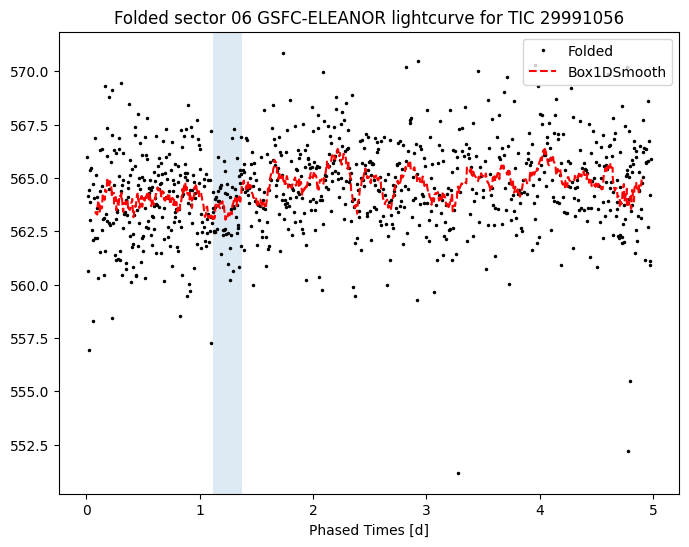

In [32]:
sector_06_lc = lk.search_lightcurve(target="TIC 29991056")[5].download()
sector_06_lc = sector_06_lc.remove_outliers(sigma_lower=8, sigma_upper=4)
vet.VizTransits(folded_plot=True).run(tce, sector_06_lc)
plt.title('Folded sector 06 GSFC-ELEANOR lightcurve for TIC 29991056')
plt.show()

{'offset': 2.3630256286062243, 'significance': array([0.94920308])}

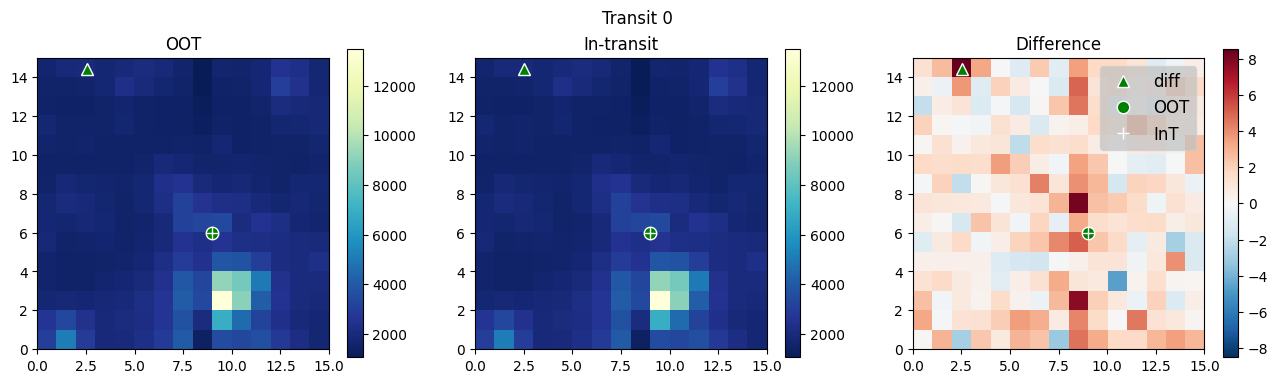

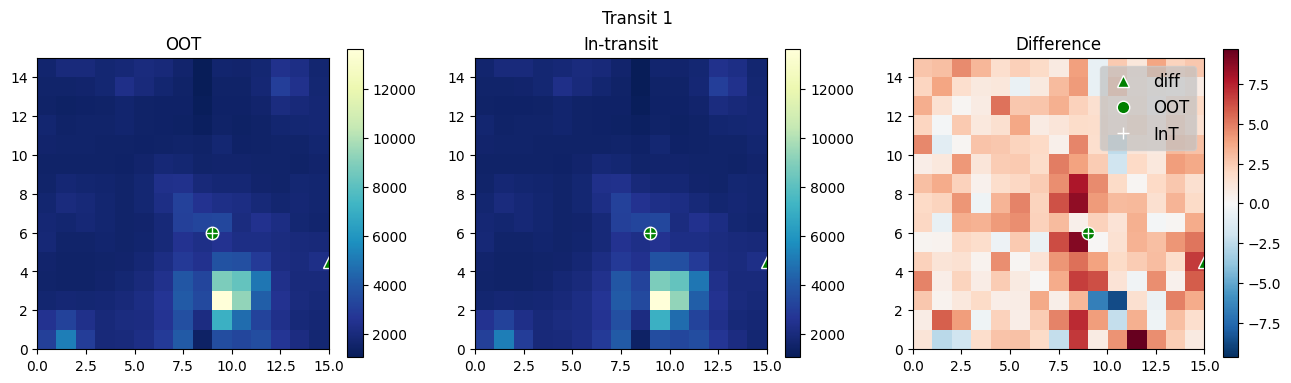

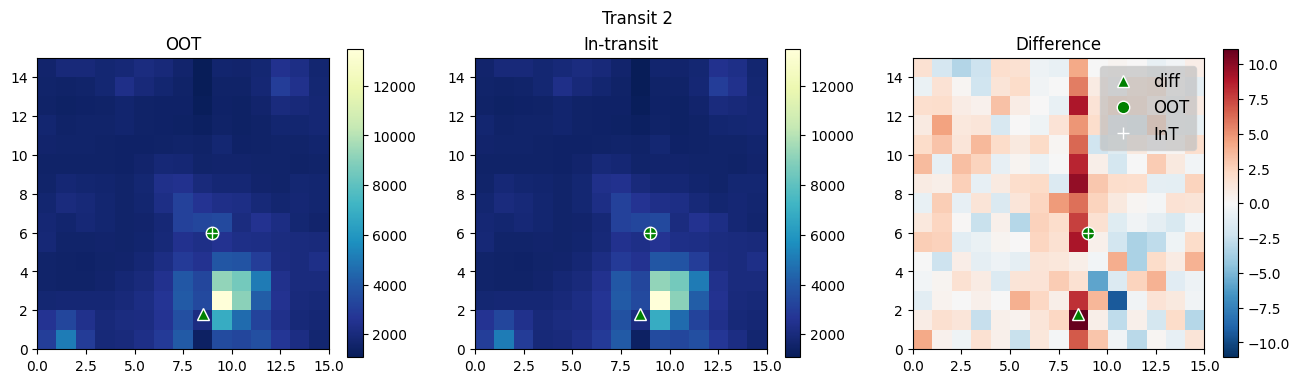

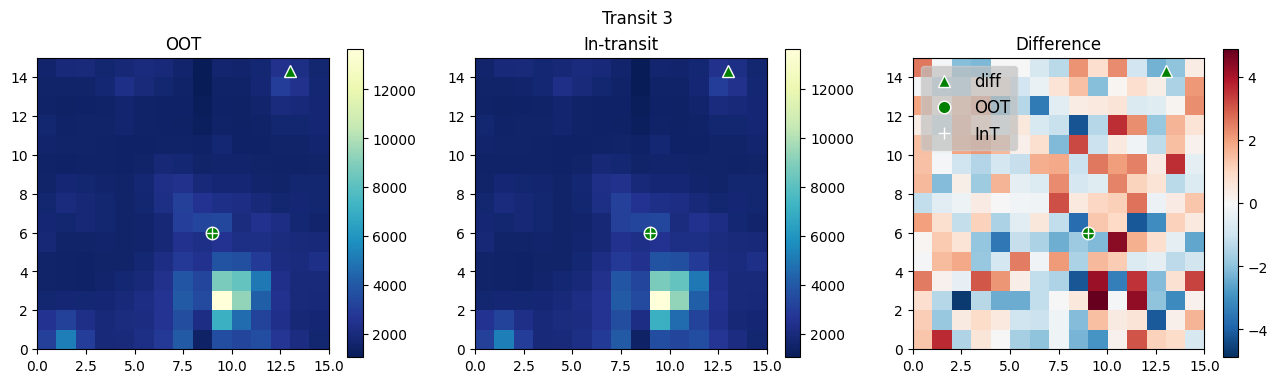

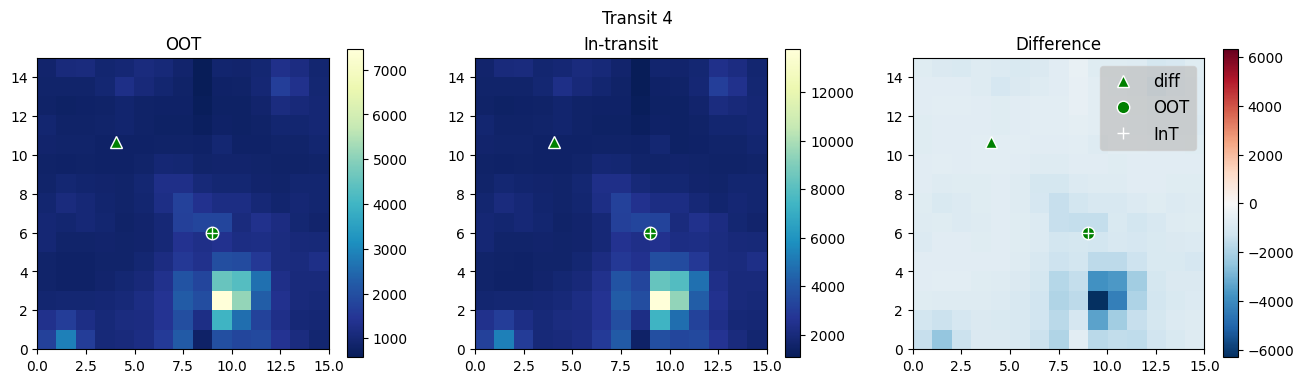

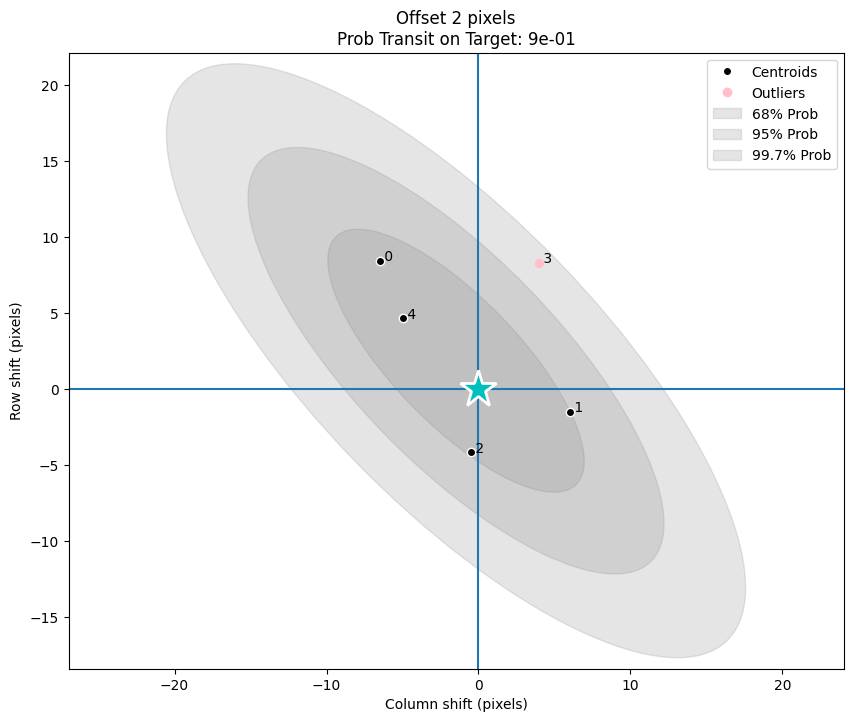

In [40]:
centroid = vet.Centroid()
centroid.run(tce, tpfs[0], plot=True)

With CentroidSectors we can take the mean of each sector's in transit, out of transit, and subsequent difference images and use these to centroid vet on: 

{'offset': 1.898370143518893, 'significance': array([0.76279681])}

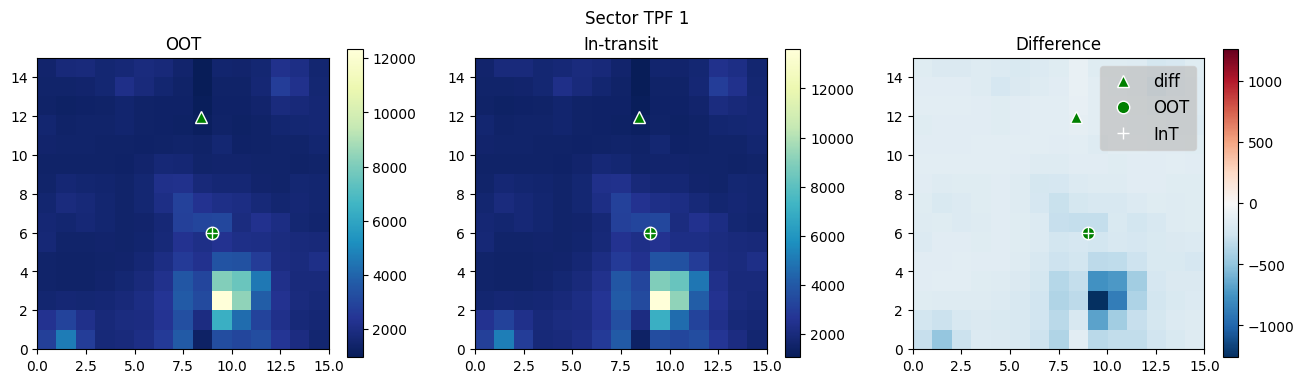

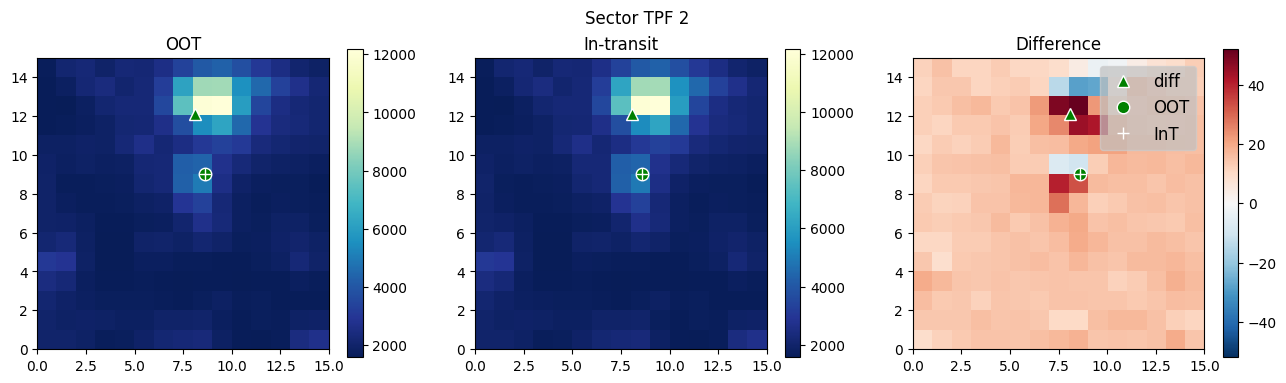

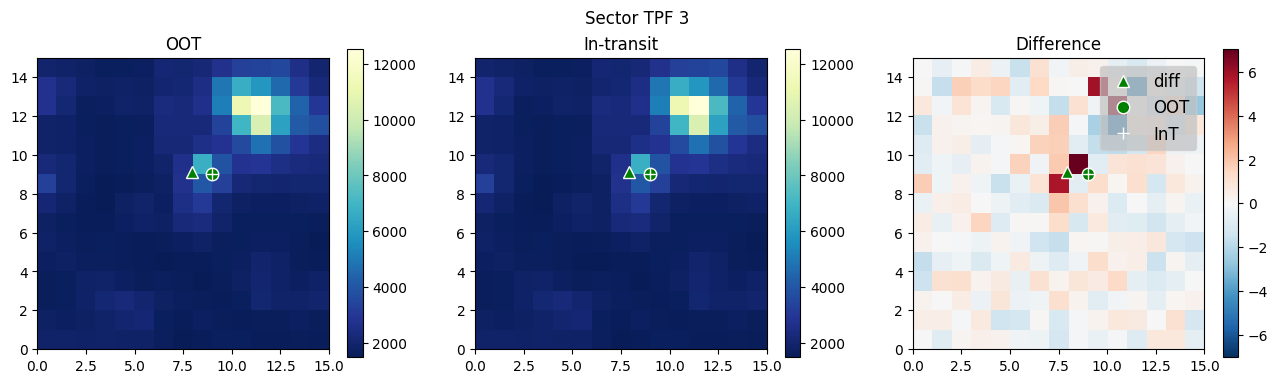

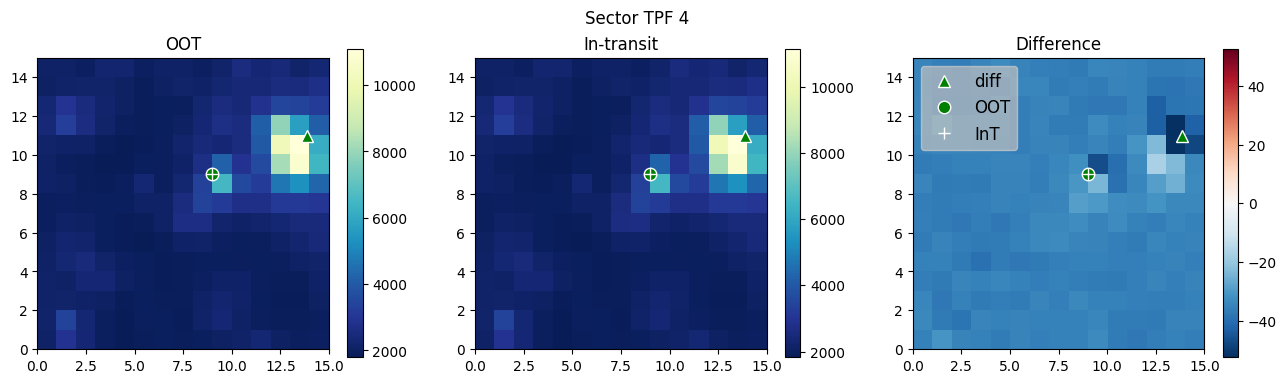

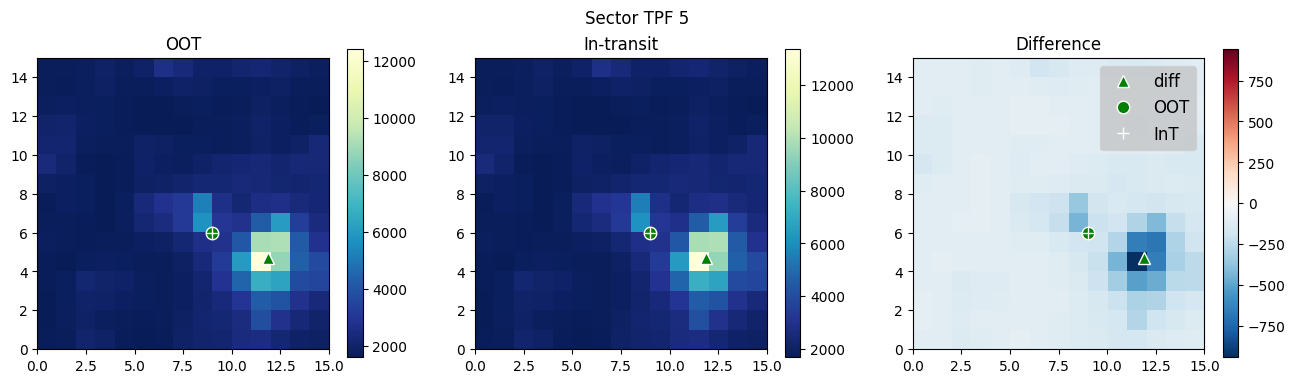

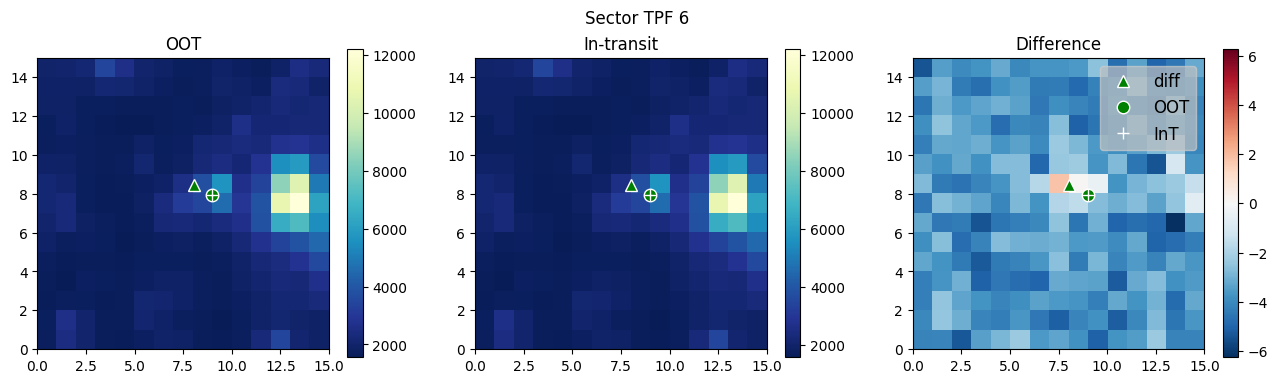

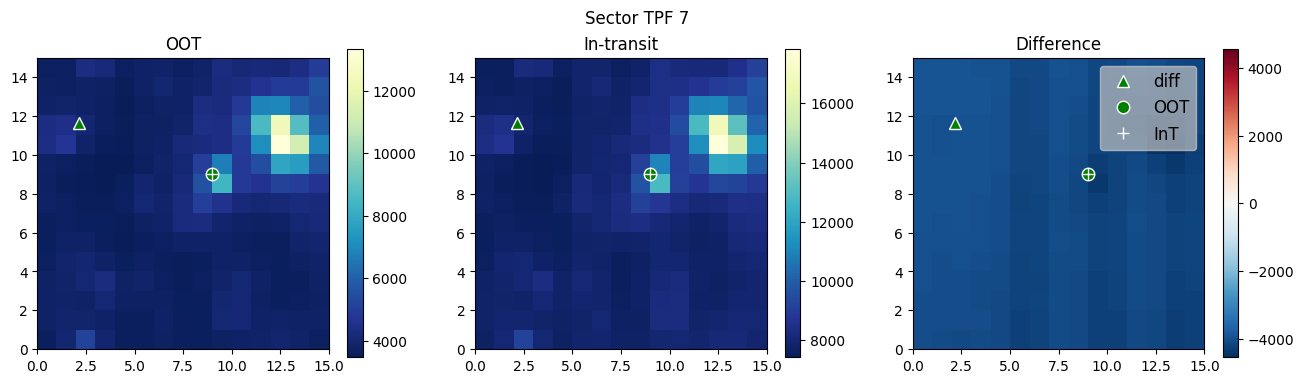

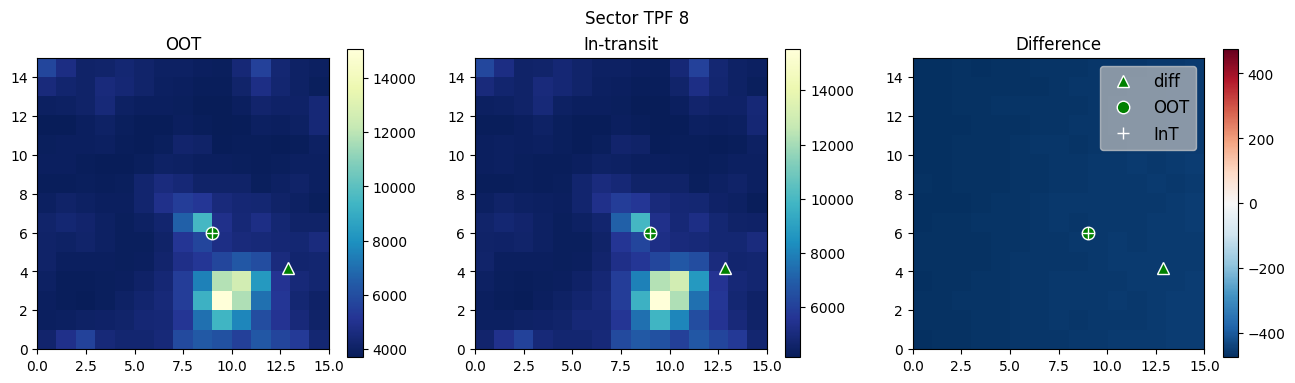

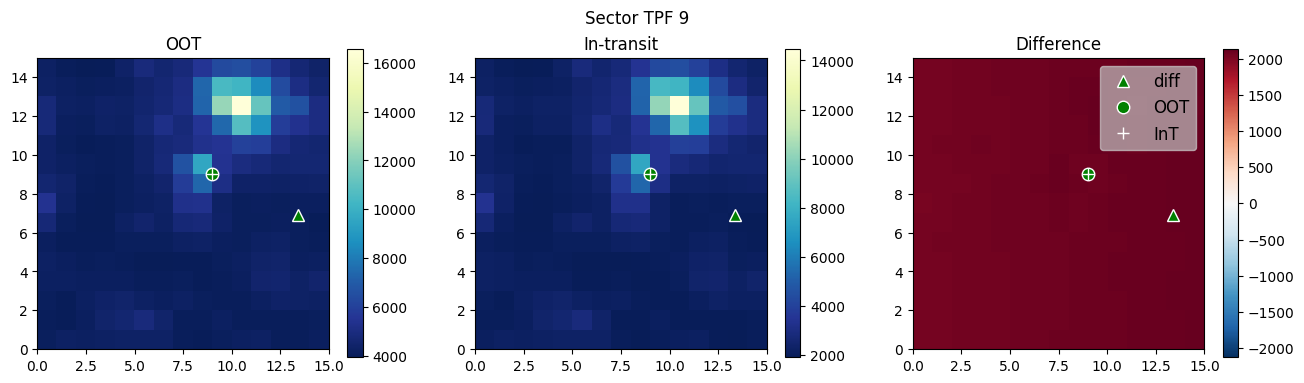

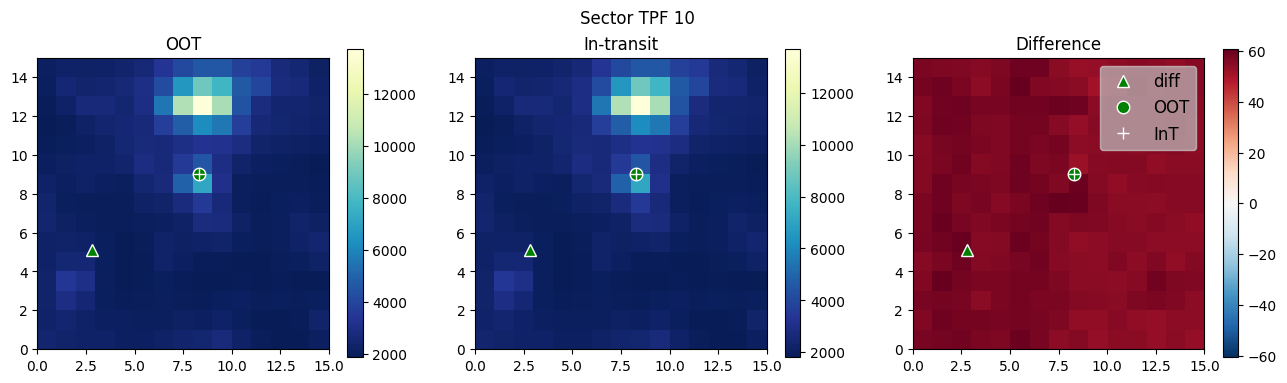

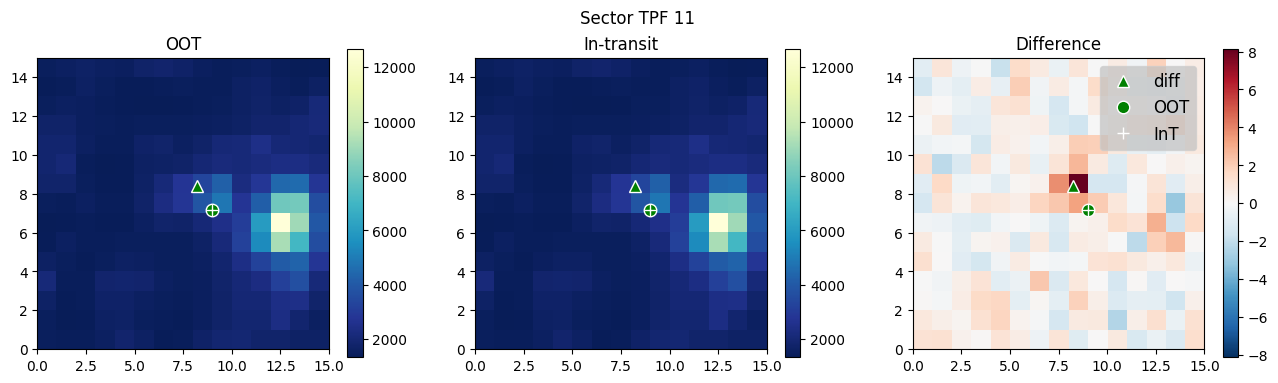

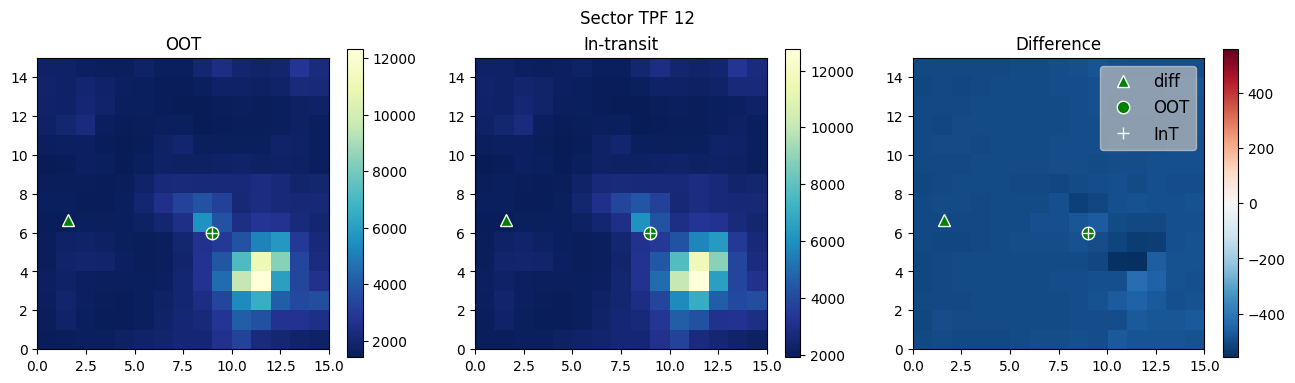

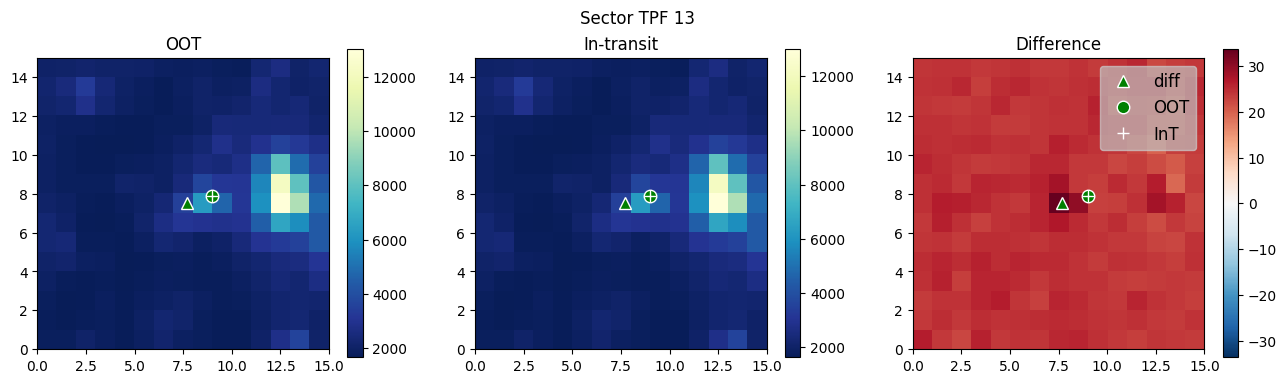

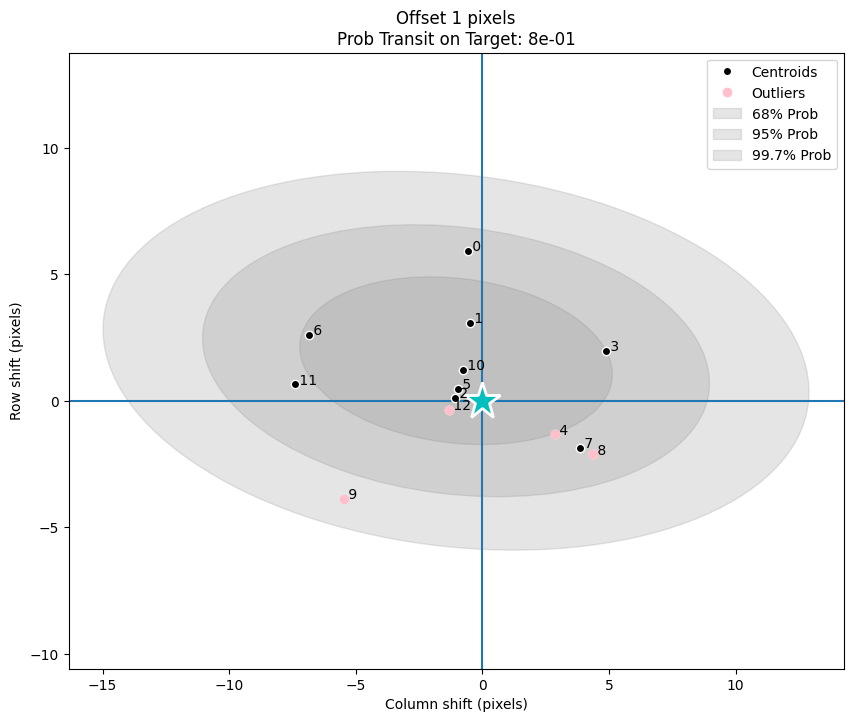

In [33]:
centroid_sector = vet.CentroidSectors()
centroid_sector.run(tce, tpfs, plot=True)

We can see however that the scales for each "sector" difference image are vastly different. This is because the mean of a sector's difference image can be dominated by one irregularly bright caused by instrumental effects such as scattered light. In sector 06 for example, the images of the last transit are much brighter than the others. 

To correct for this, we can supply the "sigma" argument to the CentroidSectors vetter, which applies sigma clipping to the median of the difference images and rejects those transits from the stack which are above it.

removed transit 5 in sector 6 from stack
removed transit 3 in sector 5 from stack
removed transit 3 in sector 3 from stack
removed transit 1 in sector 1 from stack
removed transit 4 in sector 1 from stack
removed transit 3 in sector 2 from stack
removed transit 6 in sector 2 from stack
removed transit 1 in sector 10 from stack
removed transit 4 in sector 10 from stack
removed transit 1 in sector 13 from stack
removed transit 3 in sector 11 from stack
removed transit 3 in sector 7 from stack
removed transit 1 in sector 9 from stack
removed transit 4 in sector 9 from stack


{'offset': 0.5249661951710607, 'significance': array([0.92047607])}

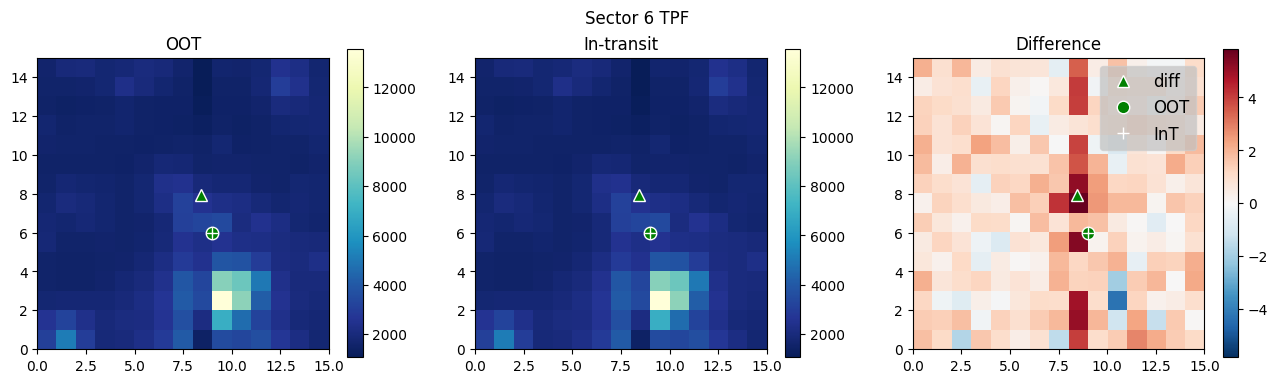

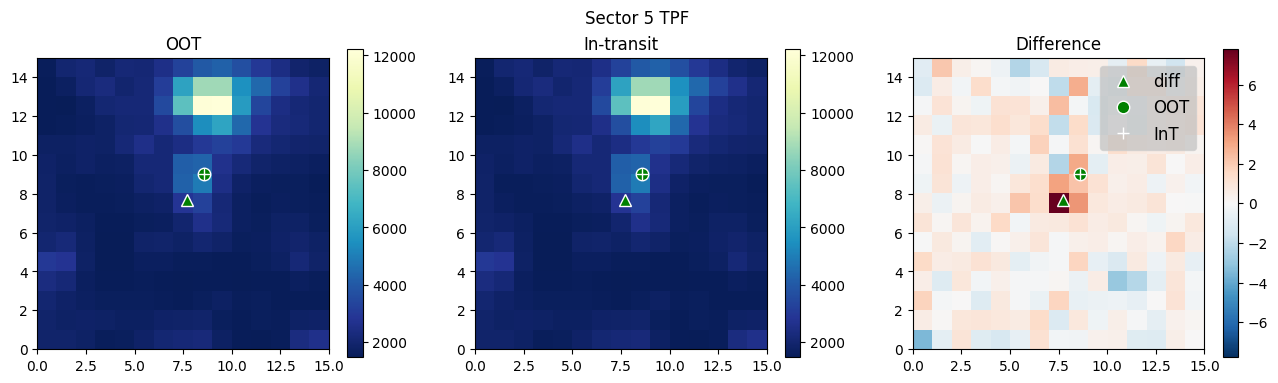

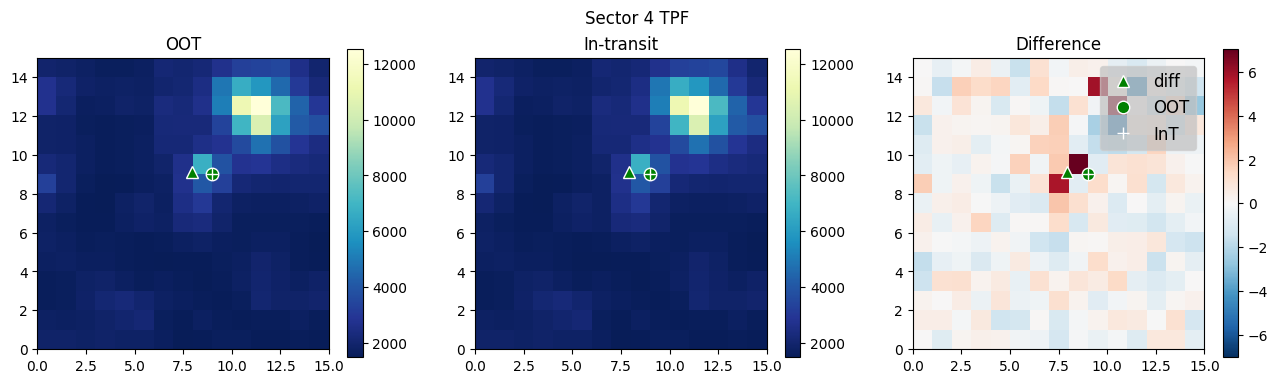

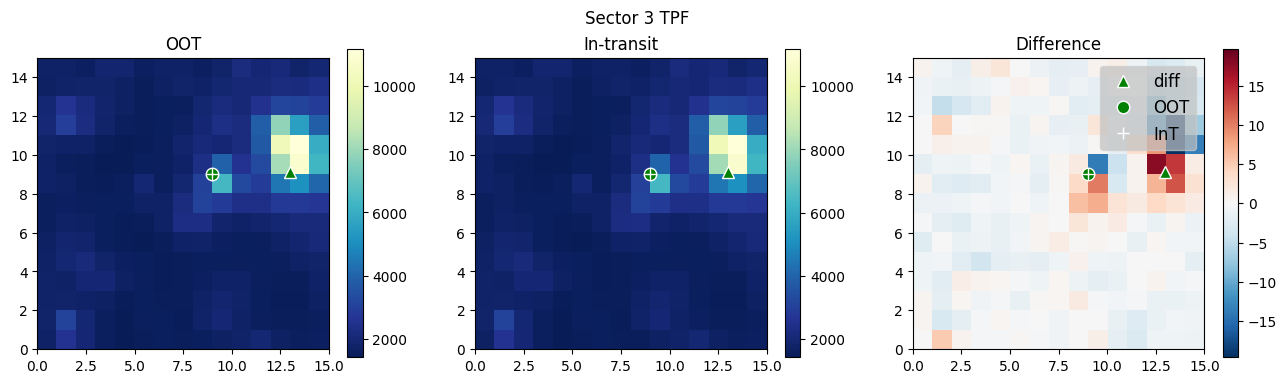

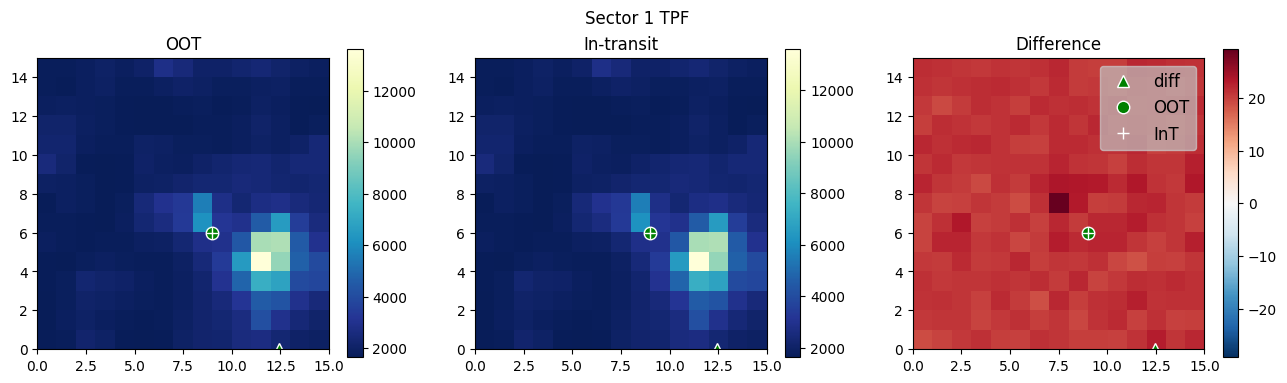

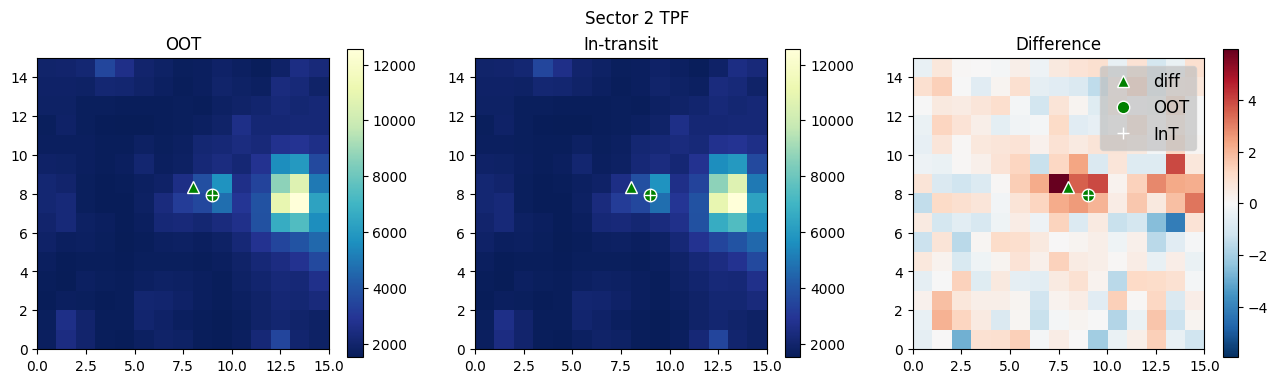

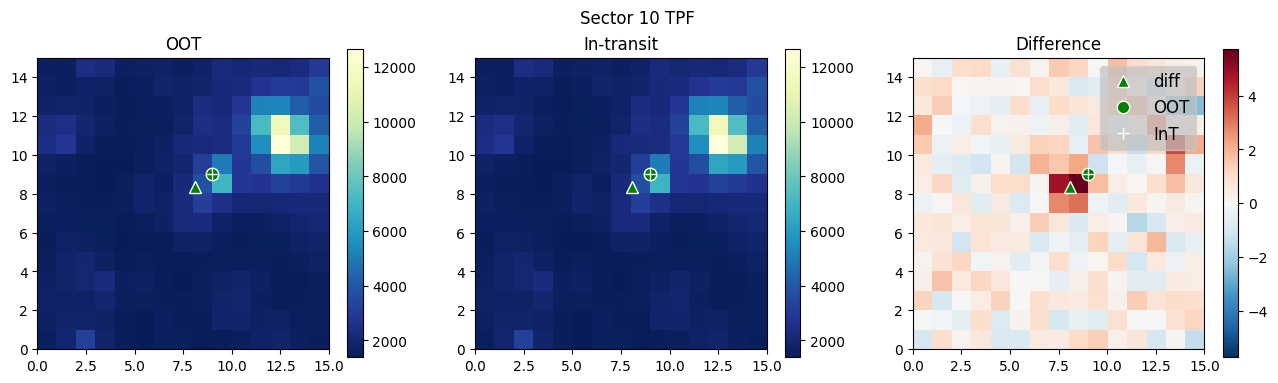

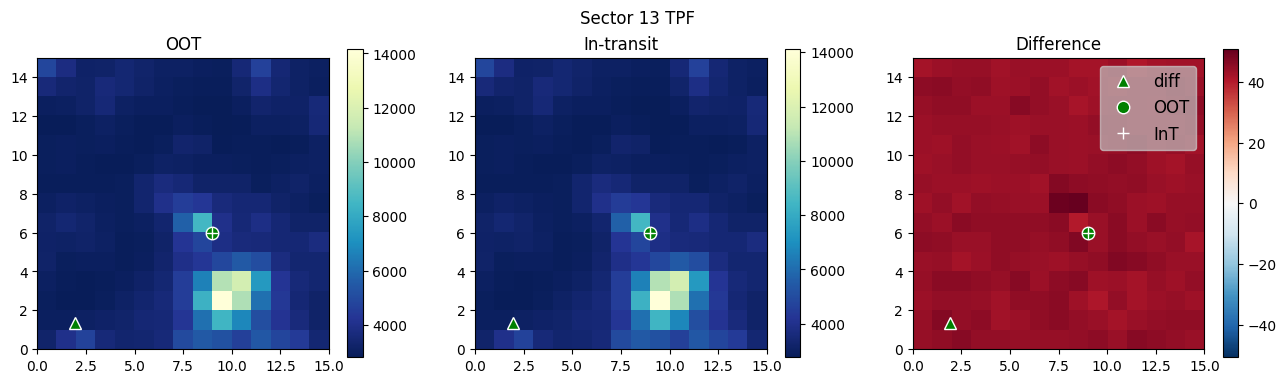

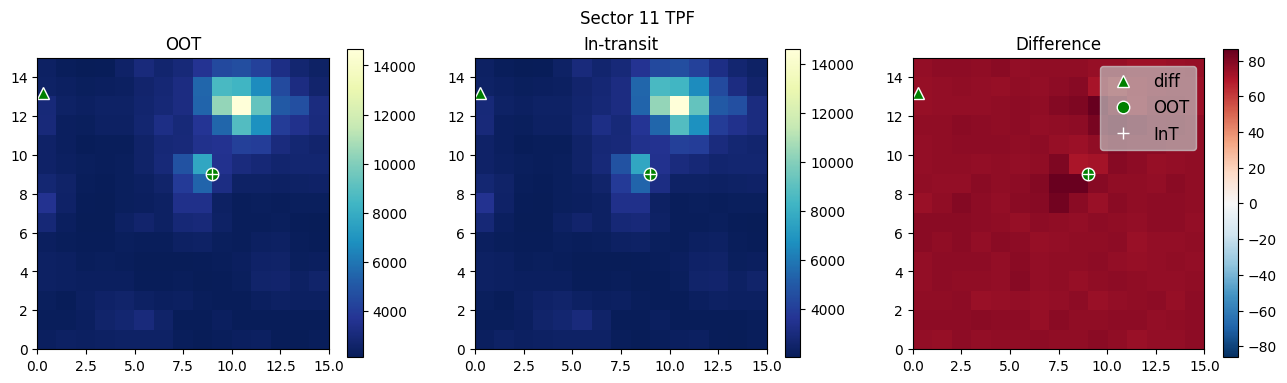

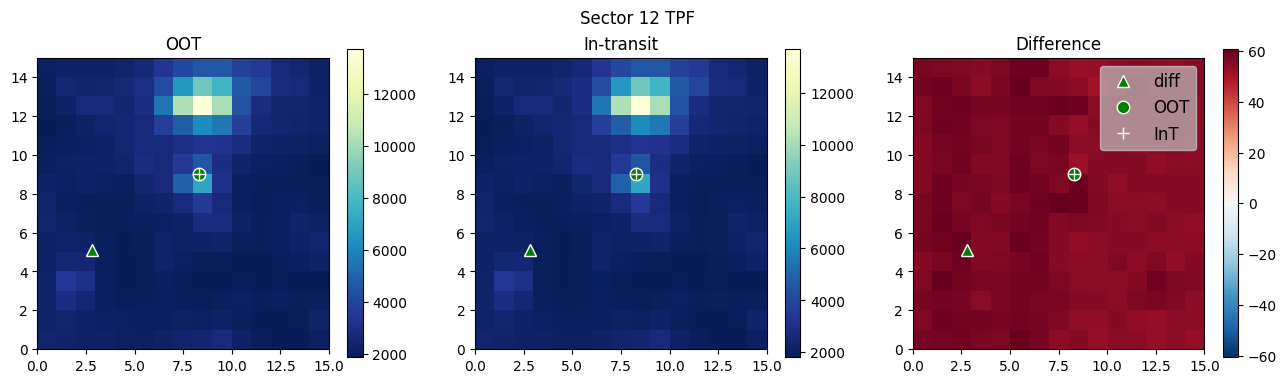

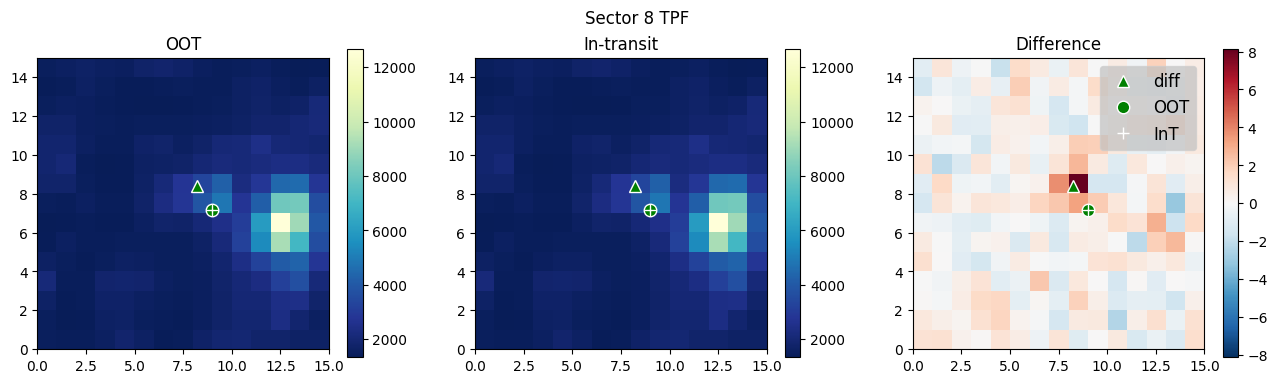

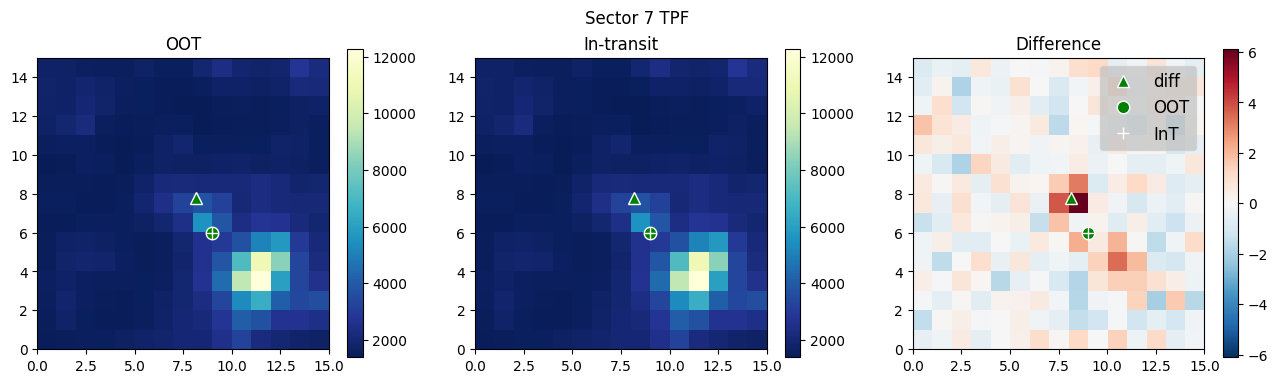

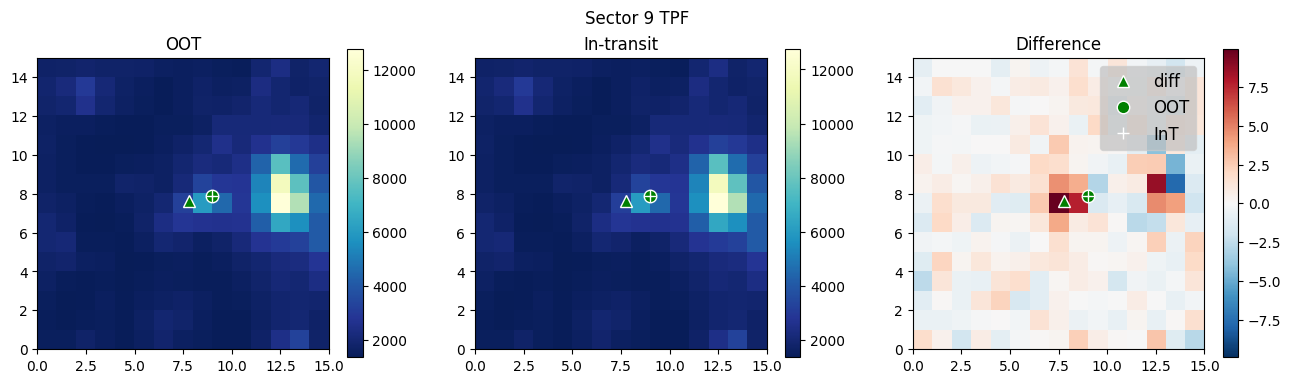

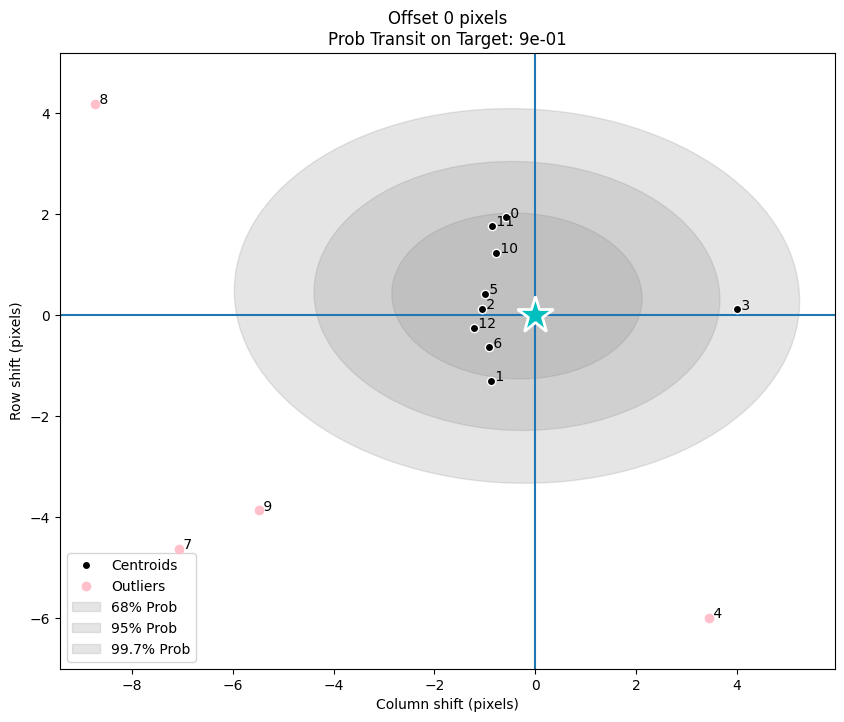

In [52]:
centroid_sector = vet.CentroidSectors()
centroid_sector.run(tce, tpfs, sigma=2, plot=True)